# week4-session1 アヤメの分類

# 2.アヤメの分類

4種類の特徴量（説明変数）からアヤメの種類を推測する問題が設定できます。アヤメの種類を分類するので、こういったものを分類問題と呼びます。

**今回使う手法の一覧**  
scikit-laernを使い以下の手法で学習と推定を行っていきます。それぞれの手法についての詳細は今の段階では扱いません。ライブラリを使えばどれも気軽に利用できることや、手法毎の結果に違いがあることを簡単に見ていきます。


- 最近傍法
- ロジスティック回帰
- SVM
- 決定木
- ランダムフォレスト

# 3.分類問題の流れ

まず、最近傍法を例に分類問題を解く基本的な流れを紹介します。課題の後半ではこれを参考に他の手法にも適用してもらいます。
この流れについては後々より深く学び、実践していきます。今回の課題では大まかな流れの把握を行ってください。

**練習のための準備**  
練習する上で結果の可視化を行いたいため、特徴量は4つの中で2つだけを使うことにします。こうすることで2次元の散布図を描き確認することができます。また、問題を単純化するためアヤメの種類を2つだけ使うことにします。分類対象が2種類の場合を 2値分類 と呼び、それ以上の 多値分類 とは区別をします。それぞれで手法や評価方法が変わります。今回はまずより基本的な2値分類を行います。



## 【課題1】練習のために特徴量とカテゴリを選択  
選び方は合計18通りありますが、以下の組み合わせで練習することにします。irisデータセットをWeek3同様に取得した後、データフレームからこれらを抜き出してください。
- versicolorとvirginica
- sepal_lengthとpetal_length

《実際の問題では？》  
実際の問題を解く上でも結果の可視化は有効です。しかし、そのために学習や推定に使う特徴量を2つに絞るのは望ましくありません。そのため学習や推定は多次元で行い、可視化をする際にだけ主成分分析などの特徴抽出手法を適用するといったことが行われます。また、Week3で利用した散布図行列を使い可視化することも可能です。

### 1.1.1（解答）

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.datasets import load_iris

In [2]:
#irisデータの読み込み
iris_dataset = load_iris()

# 得微量
X = pd.DataFrame(iris_dataset["data"])
X.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width"]

#targetを読み込み、値を品種に変更。
y = pd.DataFrame(iris_dataset["target"])
y.columns = ["target"]

#1つのデータに結合、不要な要素を削除する。
df_master = pd.concat([X, y], axis=1) 
df0 = df_master[["sepal_length", "petal_length", "target"]]
df = df0[df0["target"] != 0]

print(df.head())

    sepal_length  petal_length  target
50           7.0           4.7       1
51           6.4           4.5       1
52           6.9           4.9       1
53           5.5           4.0       1
54           6.5           4.6       1


## 【問題2】データの分析
まずはデータの分析を行いますが、これはWeek3の課題1で行いました。その際出力した散布図行列を見ることで、先ほどの18通りそれぞれの散布図も確認できます。sepal_lengthとpetal_lengthを使い、virgicolorとvirginicaを分類するのは少し難しそうな状況であることが分かるはずです。  
ここでは復習を兼ねて、抜き出したデータの散布図と箱ひげ図（boxplot）、バイオリン図（violinplot）を表示してください

《実際の問題では？》  
このデータ分析の結果を元に前処理として特徴量エンジニアリングを行っていきます。  
今回はsepal_lengthとpetal_lengthを抜き出しましたが、分析した上で、問題を少々難しくするための前処理をしたと言えます。

### 2.1.1（解答）

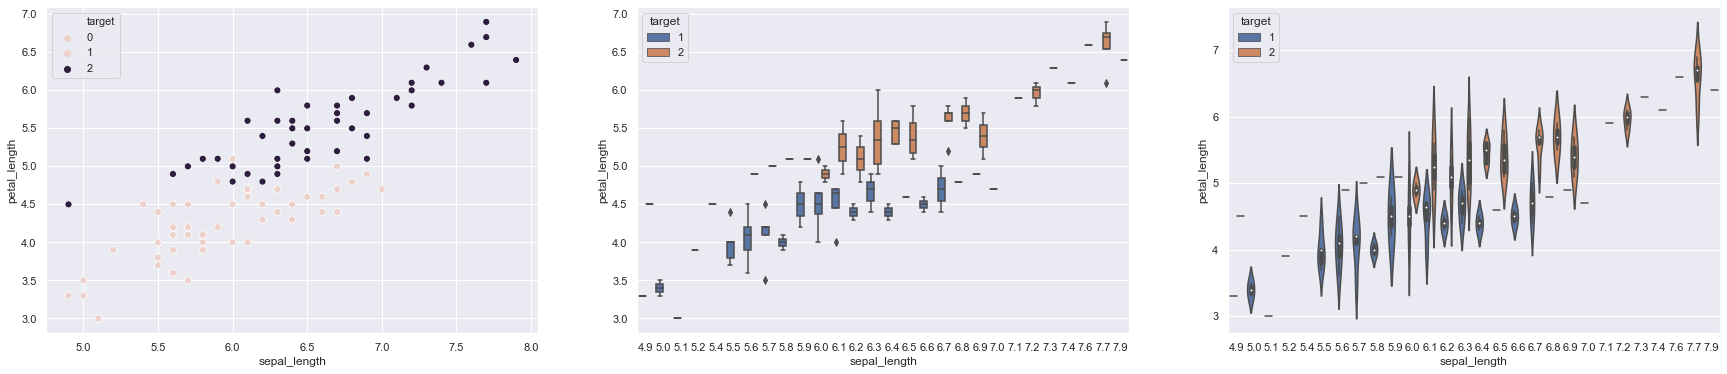

In [3]:
fig = plt.figure(figsize=(30,6))

ax1 = fig.add_subplot(1,3,1)
ax1 = sns.scatterplot("sepal_length", "petal_length", data=df, s=50, hue="target")

ax2 = fig.add_subplot(1,3,2)
ax2 = sns.boxplot("sepal_length", "petal_length", data=df, hue="target")

ax3 = fig.add_subplot(1,3,3)
ax3 = sns.violinplot("sepal_length", "petal_length", data=df, hue="target")

## 【問題3】前処理・訓練データと検証データの分割  
前処理の一貫として、訓練データと検証データの分割を行います。今回は訓練データ75%、検証データ25%として分割してください。  
scikit-learnのtrain_test_splitが利用できます。公式ドキュメントのExamplesを参考に動かしてください。  

sklearn.model_selection.train_test_split — scikit-learn 0.21.3 documentation  
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

《注意点》  
データの分析まではPandasのDataFrameを使用してきました。しかし、scikit-learnはNumPyのndarrayを想定して作られています。そのため、この段階でndarrayへの変換を行いましょう。特徴量（説明変数）をX、正解（目的変数）をyというndarrayに格納します。

《分割する理由》  
分類問題の目的は未知のデータを正しく分類することです。その目的が達成できているかを確認するため、実際には答えの分かっているデータの一部を学習には使わず残しておきます。この学習に使用していないデータで推定を行い、そこから求めた指標値によって検証します。学習に使うデータを訓練データ、検証に使うデータが検証データで、一般的に7対3から8対2程度の割合にします。

### 3.1.1（解答） 特微量と正解ラベルの設定

In [4]:
# ndarray型に変換
data = np.array(df)

# 特微量
X = data[:,:2]

# 正解ラベル
y = data[:,2:]

In [5]:
print(f"データ数 = {X.shape[0]} 特微量 = {X.shape[1]}")
pd.DataFrame(X, columns=["sepal_length", "petal_length"]).head()

データ数 = 100 特微量 = 2


,sepal_length,petal_length
0,7.0,4.7
1,6.4,4.5
2,6.9,4.9
3,5.5,4.0
4,6.5,4.6


In [6]:
print(f"正解ラベルのデータ数 = {y.shape[0]}")
print(y.reshape(1,-1))

正解ラベルのデータ数 = 100
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2.]]


### 3.2.1(解答）

In [7]:
from sklearn.model_selection import train_test_split

# 訓練データと検証データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print(f"特微量の訓練データ = {len(X_train)}  特微量の検証データ = {len(X_test)}")
print(f"正解ラベルの訓練データ = {len(y_train)} 正解ラベルの検証データ = {len(y_test)}")

特微量の訓練データ = 75  特微量の検証データ = 25
正解ラベルの訓練データ = 75 正解ラベルの検証データ = 25


## 【問題4】前処理・標準化
分類精度をあげるための加工を行います。手法ごとに適切な方法は異なりますが、ここでは一例として**標準化**を行うことにします。  
標準化を行うライブラリもscikit-learnに用意されています。これを使って標準化してください。

sklearn.model_selection.train_test_split — scikit-learn 0.21.3 documentation  
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

《注意点》  
標準化は訓練用のデータでfitを行い、訓練用、検証用双方のデータにtransformを行います。検証データは学習の段階には存在しない未知のデータの代わりなので、標準化のための平均や標準偏差の計算に使ってはいけません。また、今回は分類問題なので、ラベルについては標準化させる必要はありません。

《実際の問題での前処理は？》


アヤメのデータセットのように綺麗で扱いやすい状況で提供されることはまずありません。分析を行いながら、様々な加工が必要になってきます。例えばWeek3の課題2で行った欠損値の確認の後、場合により欠損値の補間も行います。外れ値の確認や、複数のデータセットの整理などもあります。

### 4.1.1（解説）標準化

例えば生徒全員の成績から平均点と標準偏差を求め、それぞれの生徒がどのぐらい平均と差があるかを求める方法を標準化といいます。
標準化することで平均は0に、分散（標準偏差も）は1になり、これにより異なる項目のデータであってもその大小を比較できるようになります。これを使うことで、測定単位が学習データの大きさに与える影響を取り除くことができて、AI（人工知能）の性能を上げることができます。

$$X^i_{new} =\frac{x^i-μ}{∂}$$

$μ$は平均を、$∂$は標準偏差を表します。  
参考資料　https://aizine.ai/standardscaler-0728/

### 4.1.2（解答）標準化

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# 引数を元に平均と標準を計算
scaler.fit(X_train) 

# 標準化データの作成
X_train_r = scaler.transform(X_train) 
X_test_r = scaler.transform(X_test) 

## 【問題5】学習と推定
最近傍法（k-nearest neighbors, k-nn）で学習を行います。scikit-learnの公式ドキュメントのExamplesを参考に、k-nnの学習を行ってください。ここで入力するのは訓練データです。

sklearn.neighbors.KNeighborsClassifier — scikit-learn 0.21.3 documentation  
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

学習が終わった後、検証データをpredictメソッドに入力し、推定を行ってください。  
パラメータが複数ありますが、今はそれらの理解を重視しません。最も基本的な要素として、n_neighborsの数があるため、これは複数試してみましょう。デフォルトの5、および1と3を最低限行ってください。5の場合を5-nn、3の場合を3-nnのように呼びます。

### 5.1.1（解説）最近傍法

分類（判別、予測、クラス分け、ラベル付け）したいデータの近傍にあるk個のトレーニング（学習）データを用いて分類を行うアルゴリズムです。
**乱暴にいうと分類したいデータの近傍にあるk個のトレーニングデータによる多数決**
つまり、最近傍法を使うためには対象インスタンスとインスタンスの2点間の距離、一般的にはユークリッド距離（L2距離）を計算するためのデータ（個々のインスタンスの特徴を表す数値データ（順序尺度、間隔尺度、比例尺度））と分類するためのラベルデータ（名義尺度）が必要になります。
ユークリッド距離はn次元の直交座標系であれば計算が可能ですので、主成分分析のような多変量（多変数）のフィーチャーを持つインスタンス（観測単位の具体例）を分類するのに使え、その特徴は以下の通りです。

長所
- 単純で効果的
- トレーニングデータの分布に前提条件がない
  - 分類境界が不規則な場合に効果を発揮することが多い
- トレーニングが高速

短所
- モデルを作らないので結果の理解が難しい
  - アルゴリズム自体が単純なので説明しやすいという主張もある
- kの値によって結果が変わることがある
- データが多いとトレーニング後の分類処理に時間がかかる
  - 距離を総当たり（Brute Force）で計算するため
  - 高速に計算する方法が色々と研究・実装されている（FNNパッケージなど）
- 名義フィーチャー（変数）と欠損値に対する処理が必要

参考資料　https://k-metrics.bitbucket.io/mlwr_c03.html

### 5.1.2(解答) ｋ近傍法

In [9]:
# k近傍法のインポート
from sklearn.neighbors import KNeighborsClassifier

# アルゴリズムを指定
knc = KNeighborsClassifier(n_neighbors=5) 

# 学習
knc.fit(X_train_r, y_train.ravel())

# 予測
y_pred = knc.predict(X_test_r)
print(f"分類結果は、\n{y_pred}")

分類結果は、
[1. 2. 1. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 1. 1. 2. 1. 2. 1. 1. 2. 1. 2.
 1.]


### 5.2.3（解答) 最適なK値の確認

K値は最も重要な要素で、測定する値に最も近い判断基準となる値の数を表す。  
K値を５とすると、ｘ値に近い５つの値のラベル情報の多数決でｘの値のラベルが決まる。


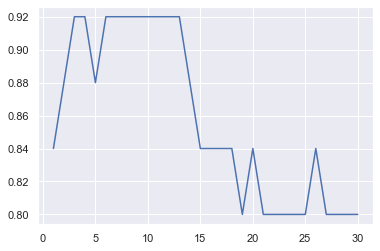

In [10]:
# グラフ化のための空リスト
list_nn = []
list_score = []
for k in range(1, 31):
    knc = KNeighborsClassifier(n_neighbors=k) 
    knc.fit(X_train_r, y_train.ravel())
    y_pred = knc.predict(X_test_r)

    # 評価（正解率）
    score = knc.score(X_test_r, y_test.ravel())
    
    # グラフ化のためのリストへの追記
    list_nn.append(k)
    list_score.append(score)
    
plt.plot(list_nn, list_score)

## 【問題6】評価
検証データの特徴量を入力して得られた推定値と、検証データの正解値の近さを計算し、学習したモデルを評価します。  
2値分類を評価するための指標値には Accuracy（正解率）、Precision（適合率）、Recall（再現率）、F値 があります。それぞれの意味を理解するには、 混同行列（confusion matrix） を見ることになります。

- scikit-learnを使い4種類の指標を計算する
- 混同行列をscikit-learnを使い表示する
- 4種類の指標値の意味について簡単に調査して文章でまとめる

sklearn.metrics.accuracy_score — scikit-learn 0.21.3 documentation  
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

sklearn.metrics.precision_score — scikit-learn 0.21.3 documentation  
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score

sklearn.metrics.recall_score — scikit-learn 0.21.3 documentation  
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score

sklearn.metrics.f1_score — scikit-learn 0.21.3 documentation  
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

sklearn.metrics.confusion_matrix — scikit-learn 0.21.3 documentation  
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix

### 6.1.1（解答） 混同行列(confusion matrix)

混同行列は二値分類（正事例と負事例の予測）の結果をまとめた表です。  
分類結果を表形式にまとめることでどのラベルを正しく分類でき、どのラベルを誤って分類したかを調べることが出来ます。

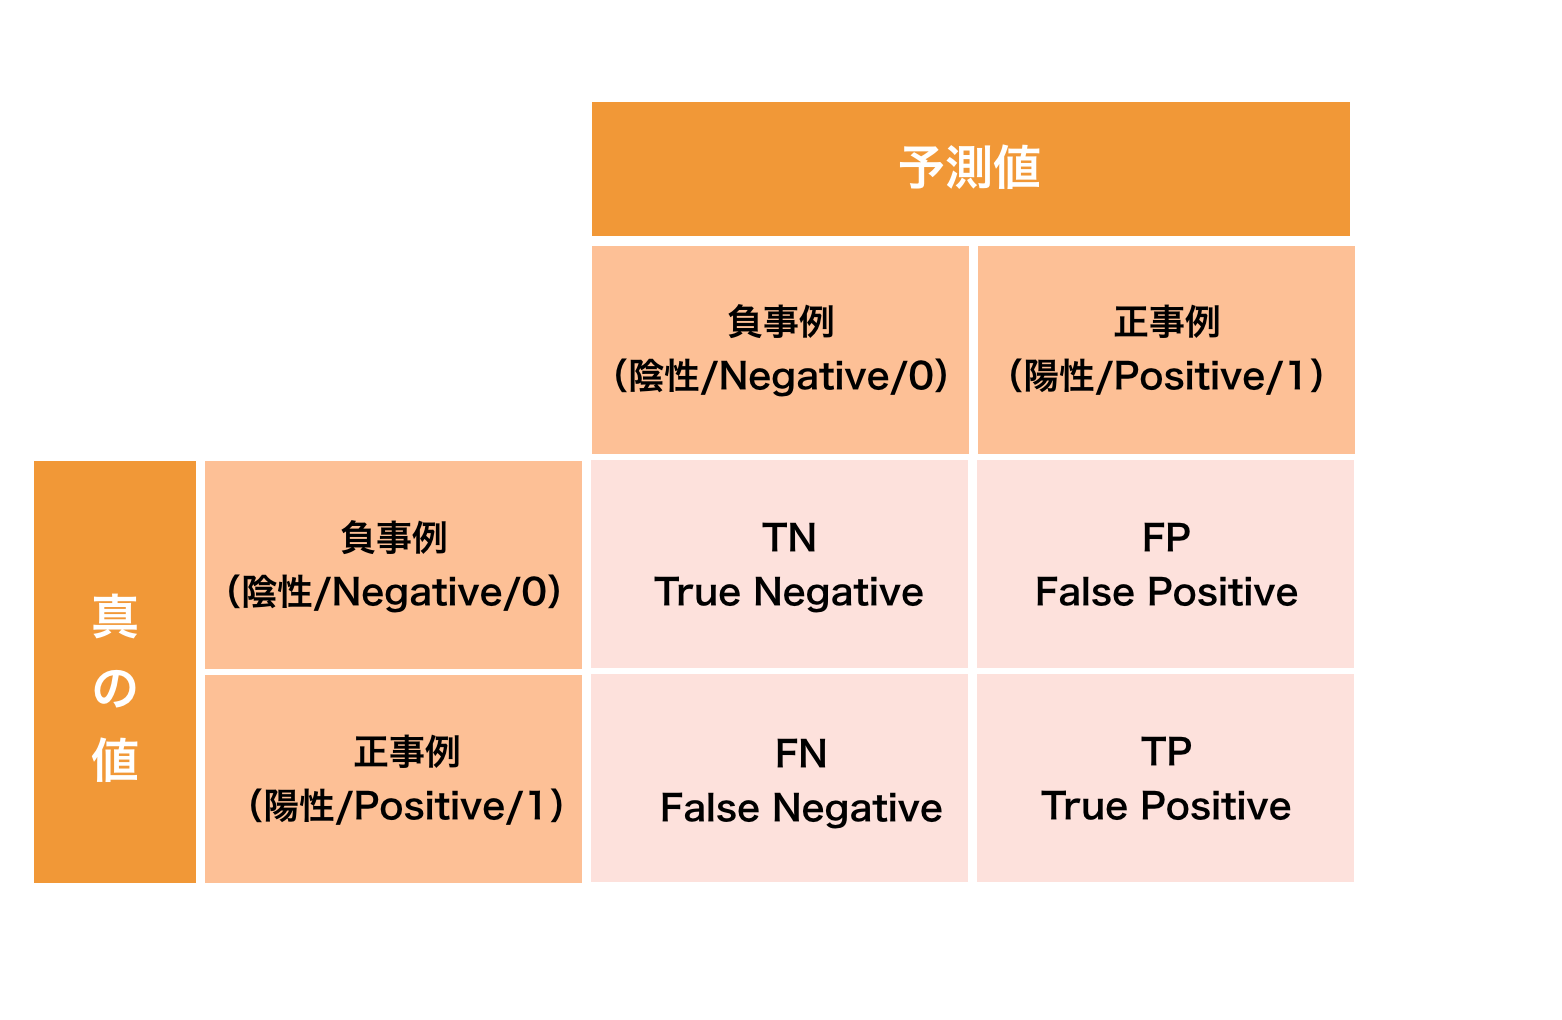

- True Positive(TP) ・・・真の値が正事例のものに対して、正事例と予測したもの (真陽性)  
- False Positive(FP) ・・・真の値が負事例のものに対して、正事例と予測したもの(偽陽性)
- False Negative(FN) ・・・真の値が正事例のものに対して、負事例と予測したもの(偽陰性)
- True Negative(TN) ・・・真の値が負事例のものに対して、負事例と予測したもの(真陰性)

このTP、FP、FN、TNの値を可視化したものが混同行列です。

In [11]:
# confusion matrixのインポート
from sklearn.metrics import confusion_matrix

# confusion matrixを出力
cmatrix = confusion_matrix(y_test, y_pred) 
print(f"confusion matrixの値:\n{cmatrix}" )

# confusion matrixのそれぞれの値を習得
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("TN", tn)
print("FP", fp)
print("FN", fn)
print("TP", tp)

confusion matrixの値:
[[ 9  4]
 [ 1 11]]
TN 9
FP 4
FN 1
TP 11


### 6.2.1（解答） 正解率(Accuracy)

予測結果全体がどれくらい真の値と一致しているかを表す指標です。  
注意すべき点は、正解率が高ければよいモデルというわけではないということです。  
以下の式で求められます。

$$Accuracy =\frac{TP+TN}{TP+FP+FN+TN} $$



In [12]:
# accuacyのインポート
from sklearn.metrics import accuracy_score

print("Accuracu:",accuracy_score(y_test, y_pred))

Accuracu: 0.8


### 6.3.1(解答） 適合率（Precision）又は精度とも呼ばれる

適合率とは、正事例と予測したもののなかで真の値が正事例の割合を表す指標です。（出力した結果がどの程度正解していたのかを表す指標）  
適合率を重視するときはFN(False Negative)が発生することが許容できるケースです。例えば、利用シーンは、レコメンドや検索結果などです。  
適合率は以下の式で求めることができます。

$$Precision=\frac{TP}{TP+FP}$$

In [13]:
# precision＿scoreをインポート
from sklearn.metrics import precision_score
print("Precision:",precision_score(y_test, y_pred))

Precision: 0.9


### 6.4.1（解答）再現率（Recall） 別名、感度やヒット率、真陽性率

真の値が正事例のもののなかで正事例と予測した割合を表す指標です。  
再現率を重視するときはFP(False Positive)が発生することが許容できるケースです。
利用シーンは、がん診断などです。

$$ Recall=\frac{TP}{TP+FN}$$

In [14]:
#recall_scoreのインポート
from sklearn.metrics import recall_score
print("Recall:",recall_score(y_test, y_pred))

Recall: 0.6923076923076923


### 6.5.1（解答） F値（F-measure）

適合率と再現率はトレードオフの関係にあるので、2つの指標をまとめた指標としてF値があります。  
F値は、適合率と再現率の調和平均によって計算されます。
$$F-measure=\frac{2Precision \times Recall}{Precision+Recall} $$ 

In [15]:
# f1_scoreのインポート
from sklearn.metrics import f1_score
print("f1_score:",f1_score(y_test, y_pred))

f1_score: 0.7826086956521738


### 6.6.1（予備知識） 適合率、再現率、F値をまとめて出力

In [16]:
#classification_reportのインポート
from sklearn.metrics import classification_report
print("Classification_report:\n", classification_report(y_test, y_pred))

Classification_report:
               precision    recall  f1-score   support

         1.0       0.90      0.69      0.78        13
         2.0       0.73      0.92      0.81        12

    accuracy                           0.80        25
   macro avg       0.82      0.80      0.80        25
weighted avg       0.82      0.80      0.80        25



## 【問題7】可視化  
評価の一貫として可視化を行います。今回の場合2次元の特徴量で分類を行いましたから、散布図で可視化が可能です。以下にどう分割するかという 決定領域 を描く関数を用意しました。これを利用して可視化を行ってください。Xとyには訓練データまたは検証データを与えます。

In [17]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """    
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    
    # pred
    # 『sepal_length, petal_length』の値を元に座標ベクトルを作成し、meshgred()で座標行列を返す。
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    # ２つの座標行列を結合
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    # 学習モデルから予測を出し、mesh_f1と同じ座標に変換。
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

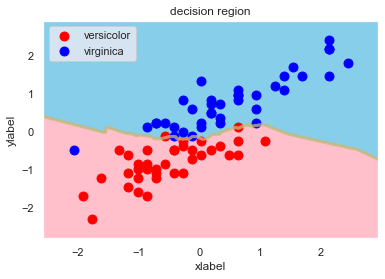

In [18]:
# アルゴリズムを指定。K最近傍法を採用
knc = KNeighborsClassifier(n_neighbors=3)
# 学習
knc = knc.fit(X_train_r, y_train.ravel())
# 関数使用
decision_region(X_train_r, y_train.ravel(), model= knc)

# 4.各手法の比較
他の手法も基本的な流れは同様です。他の手法でも学習から可視化までを行っていきます。

##  【問題8】他の手法の学習
以下の全ての手法について学習・推定・評価・可視化を行ってください。そして、指標値を１つの表にまとめてください。その表と決定領域を利用して結果を簡単に考察してください。どの手法がどの指標値で良かったかや、どういった決定領域になっていたかを述べてください。

《実際の問題では？》  
ハイパーパラメータの調整は パラメータチューニング と呼ばれる工程で、その手法としてグリッドサーチなどが存在します。

### 8.1.1 ベースデータまとめ



In [19]:
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):   
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    model = model.fit(X, y)
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        print(target)
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

In [20]:
#score
def score(X, y, X1, y1, model):
    model.fit(X, y)
    y_pred = model.predict(X1)
    print(f"Accuracu:{accuracy_score(y1, y_pred)*100:.1f}%")
    print(f"Precision:{precision_score(y1, y_pred)*100:.1f}%")
    print(f"Recall:{recall_score(y1, y_pred)*100:.1f}%")
    print(f"f1_score:{f1_score(y1, y_pred)*100:.1f}")

### 8.2.1 最近傍法
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

1.0
2.0


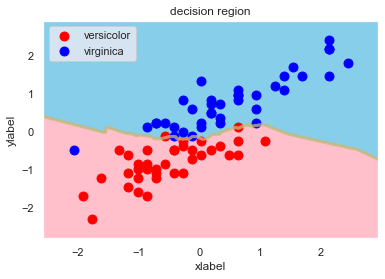

Accuracu:92.0%
Precision:100.0%
Recall:84.6%
f1_score:91.7


In [21]:
# アルゴリズムを指定
knc = KNeighborsClassifier(n_neighbors=3)
# グラフ関数
decision_region(X_train_r, y_train.ravel(), model = knc)
# 評価
score(X_train_r, y_train.ravel(), X_test_r, y_test, knc)

### 8.3.1 ロジスティック回帰
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

ロジスティック回帰は、線形分類問題と二値分類問題に対する分類モデルで、2つのグループに分けたい問題(線形分離可能な問題)にロジスティック回帰を活用できます。  
具体的には任意の値を０から１に置き換えるシグモイド関数を用いて、与えられたデータから2つに分けます。

1.0
2.0


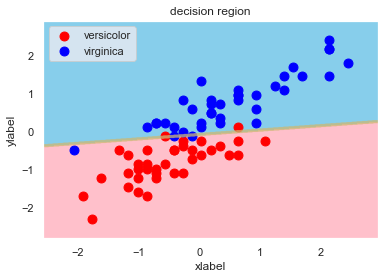

Accuracu:92.0%
Precision:100.0%
Recall:84.6%
f1_score:91.7


In [22]:
# インストール
from sklearn.linear_model import LogisticRegression
# アルゴリズムを指定
lsr = LogisticRegression()
# グラフ関数
decision_region(X_train_r, y_train.ravel(), model=lsr)
# 評価関数
score(X_train_r, y_train.ravel(), X_test_r, y_test, lsr)

### 8.4.1 SMV(サポートベクターマシン）
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

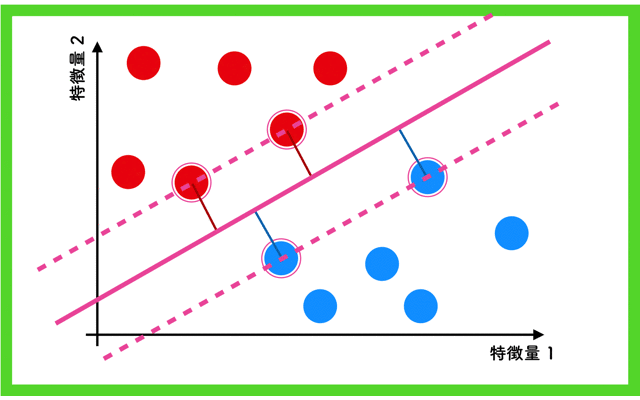

SVMとは，クラスを明確に分ける境界線を引くための手法です、上の図の例では，赤と青のクラスを明確に分ける境界線を引いてます。  
SVMでマージン最大化するにあたって，必要な前提があります。それは，データが線形分離可能であることです、すなわち，二つのクラス（例だと赤か青か）を持つデータでなければいけません。

1.0
2.0


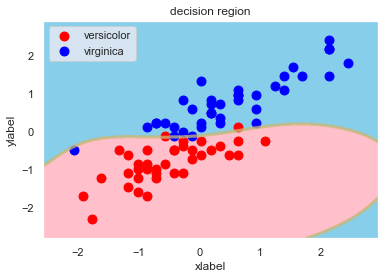

Accuracu:92.0%
Precision:100.0%
Recall:84.6%
f1_score:91.7


In [23]:
# インストール
from sklearn.svm import SVC
# アルゴリズムを指定
svm = SVC(kernel='rbf', C=1.0)
# グラフ関数
decision_region(X_train_r, y_train.ravel(), model=ｓｖｍ)
# 評価関数
score(X_train_r, y_train.ravel(), X_test_r, y_test, svm)

### 8.5.1 決定木
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

決定木とは、分類木と回帰木を組み合わせたもので、ツリーによってデータを分析する手法です。決定木は教師あり学習の代表的な分析手法で、質問と正解（教師データ）のデータセットが学習データとして与えられます。区分の分類を行いたい場合は分類木を使い、数値を予想したい場合は回帰木を使いましょう。

参考資料  https://cacoo.com/ja/blog/what-is-decision-tree/#i

1.0
2.0


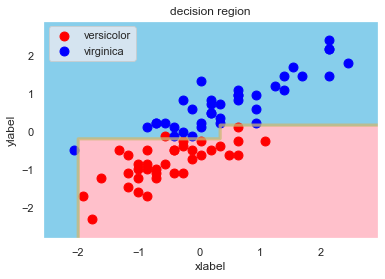

Accuracu:88.0%
Precision:100.0%
Recall:76.9%
f1_score:87.0


In [24]:
# インストール
from sklearn.tree import DecisionTreeClassifier
# アルゴリズムを指定
tree = DecisionTreeClassifier(max_depth=3)
# グラフ関数
decision_region(X_train_r, y_train.ravel(), model=tree)
# 評価関数
score(X_train_r, y_train.ravel(), X_test_r, y_test, tree)

### 8.6.1 ランダムフォレスト
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

複数の決定木を集めて多数決をとる分析手法です。学習範囲が異なる複数の決定木を集めてアンサンブル学習を行うことで、単独の決定木よりも優れた分析結果を得ることができます。

1.0
2.0


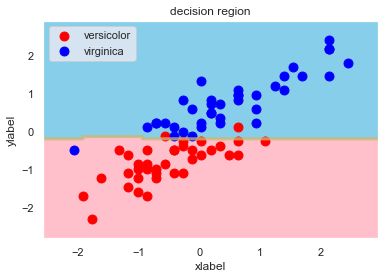

Accuracu:84.0%
Precision:100.0%
Recall:69.2%
f1_score:81.8


In [25]:
# インストール
from sklearn.ensemble import RandomForestClassifier
# アルゴリズムを指定
rfc = RandomForestClassifier(max_depth=2)
# グラフ関数
decision_region(X_train_r, y_train.ravel(), model=rfc)
# 評価関数
score(X_train_r, y_train.ravel(), X_test_r, y_test, rfc)

### 8.7.1 （解答）まとめた指標値

In [26]:
def score_data(z, model):
    x, y, x1, y1 = z
    model = model.fit(x, y)
    y_pred = model.predict(x1)
    accuracy = accuracy_score(y1, y_pred)
    precision = precision_score(y1, y_pred)
    recall = recall_score(y1, y_pred)
    f1 = f1_score(y1, y_pred)
    return accuracy, precision, recall, f1

In [27]:
score_list = [X_train_r, y_train.ravel(), X_test_r, y_test]
knc_score = np.array(score_data(score_list, knc)).reshape(-1,1)
lsr_score = np.array(score_data(score_list, lsr)).reshape(-1,1)
svm_score = np.array(score_data(score_list, svm)).reshape(-1,1)
tree_score = np.array(score_data(score_list, tree)).reshape(-1,1)
rfc_score = np.array(score_data(score_list, rfc)).reshape(-1,1)

score_data = np.concatenate([knc_score, lsr_score, svm_score, tree_score, rfc_score], 1)
score_df = pd.DataFrame(score_data)
score_df.index = ["accuracy", "precision", "recall", "f1"]
score_df.columns = ["knc", "lsr", "svm", "tree", "rfc"]
score_df

,knc,lsr,svm,tree,rfc
accuracy,0.920000,0.920000,0.920000,0.880000,0.840000
precision,1.000000,1.000000,1.000000,1.000000,1.000000
recall,0.846154,0.846154,0.846154,0.769231,0.692308
f1,0.916667,0.916667,0.916667,0.869565,0.818182


最近傍法、ロジスティクス回帰、SVMは、１つの値が誤った答えとなり、全ての指標値で１番良い結果となりました。  
次に決定木が２つ誤りで次点、最後が３つ誤りのランダムフォレストでした。

## 【問題9】（アドバンス課題）標準化の有無の比較
前処理として標準化を行いましたが、これを行わなかった場合どのような結果が得られるでしょうか。各手法に対しての指標値の表と決定領域の図を作成し比較および考察を行ってください。考察には標準化が機械学習の前処理としてどのような意味があるかを絡めてください。

### 9.1.1 最近傍法

1.0
2.0


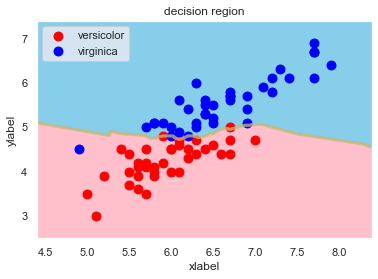

Accuracu:92.0%
Precision:100.0%
Recall:84.6%
f1_score:91.7


In [28]:
# アルゴリズムを指定
knc = KNeighborsClassifier(n_neighbors=3)
# グラフ関数
decision_region(X_train, y_train.ravel(), model= knc)
# 評価関数
score(X_train, y_train.ravel(), X_test, y_test, knc)

### 9.2.1 ロジスティック回帰

1.0
2.0


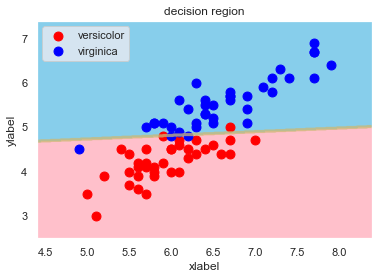

Accuracu:88.0%
Precision:100.0%
Recall:76.9%
f1_score:87.0


In [29]:
# アルゴリズムを指定
lsr = LogisticRegression()
# グラフ関数
decision_region(X_train, y_train.ravel(), model=lsr)
# 評価関数
score(X_train, y_train.ravel(), X_test, y_test, lsr)

### 9.3.1 SVM（サポートベクターマシン）

1.0
2.0


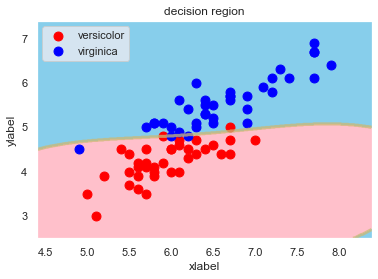

Accuracu:92.0%
Precision:100.0%
Recall:84.6%
f1_score:91.7


In [30]:
# アルゴリズムを指定
svm = SVC(kernel='rbf', C=1.0)
# グラフ関数
decision_region(X_train, y_train.ravel(), model=ｓｖｍ)
# 評価関数
score(X_train, y_train.ravel(), X_test, y_test, svm)

### 9.4.1 決定木

1.0
2.0


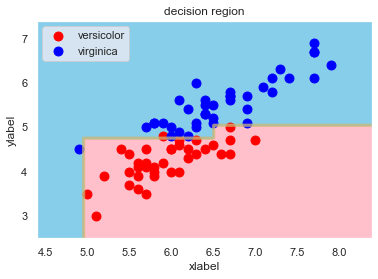

Accuracu:88.0%
Precision:100.0%
Recall:76.9%
f1_score:87.0


In [31]:
# アルゴリズムを指定
tree = DecisionTreeClassifier(max_depth=3)
# グラフ関数
decision_region(X_train, y_train.ravel(), model=tree)
# 評価関数
score(X_train, y_train.ravel(), X_test, y_test, tree)

### 9.5.1 ランダムフォレスト

1.0
2.0


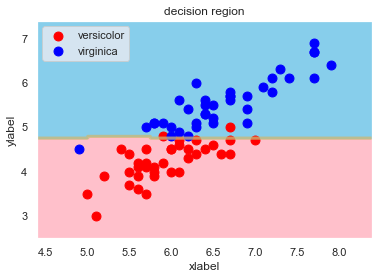

Accuracu:84.0%
Precision:100.0%
Recall:69.2%
f1_score:81.8


In [32]:
# アルゴリズムを指定
rfc = RandomForestClassifier(max_depth=2)
# グラフ関数
decision_region(X_train, y_train.ravel(), model=rfc)
# 評価関数
score(X_train, y_train.ravel(), X_test, y_test, rfc)

### 9.6.1 （解答）まとめた指標値

In [33]:
def score_data2(z, model):
    x, y, x1, y1 = z
    model = model.fit(x, y)
    y_pred = model.predict(x1)
    accuracy = accuracy_score(y1, y_pred)
    precision = precision_score(y1, y_pred)
    recall = recall_score(y1, y_pred)
    f1 = f1_score(y1, y_pred)
    return accuracy, precision, recall, f1

In [34]:
score_list2 = [X_train, y_train.ravel(), X_test, y_test]
knc_score2 = np.array(score_data2(score_list2, knc)).reshape(-1,1)
lsr_score2 = np.array(score_data2(score_list2, lsr)).reshape(-1,1)
svm_score2 = np.array(score_data2(score_list2, svm)).reshape(-1,1)
tree_score2 = np.array(score_data2(score_list2, tree)).reshape(-1,1)
rfc_score2 = np.array(score_data2(score_list2, rfc)).reshape(-1,1)

score_data2 = np.concatenate([knc_score2, lsr_score2, svm_score2, tree_score2, rfc_score2], 1)
score_df2 = pd.DataFrame(score_data2)
score_df2.index = ["accuracy", "precision", "recall", "f1"]
score_df2.columns = ["knc", "lsr", "svm", "tree", "rfc"]
score_df2

,knc,lsr,svm,tree,rfc
accuracy,0.920000,0.880000,0.920000,0.880000,0.840000
precision,1.000000,1.000000,1.000000,1.000000,1.000000
recall,0.846154,0.769231,0.846154,0.769231,0.692308
f1,0.916667,0.869565,0.916667,0.869565,0.818182


ロジスティック回帰のみ正解率が低下したが、それ以外の手法は何も変化は見られなかった。

## 【問題10】（アドバンス課題）全ての目的変数を使用して精度が高い手法
ここまではアヤメの種類を減らし2値分類を行ってきましたが、3種類全てを使った多値分類を行います。学習と推定、評価を行って、最も精度の高い手法を探してください。

《多値になることでの変更点》  
指標値Precision（適合率）、Recall（再現率）、F値はライブラリのパラメータをデフォルトから変更する必要があります。マイクロ平均やマクロ平均という考え方を使います。  
決定領域を可視化する前述の関数は適切に書き換える必要があります。以下が出力例です。

ロジスティック回帰やSVMは2値分類を基本とした手法で、多値分類には工夫が必要ですが、scikit-learnでは自動的に判断して処理が行われるため変更は必要ありません。

### 10.1.1 前処理

In [35]:
# マスターデータ
print(f"データ数 ： {df0.shape[0]} 特微量 : {df0.shape[1]}")
print(df0.head())

# 特微量と正解ラベルに分ける
data1 = np.array(df0) # ndarray型に変換
X1 = data1[:,:2] # 特微量
y1 = data1[:,2:] # 正解ラベル

データ数 ： 150 特微量 : 3
   sepal_length  petal_length  target
0           5.1           1.4       0
1           4.9           1.4       0
2           4.7           1.3       0
3           4.6           1.5       0
4           5.0           1.4       0


In [36]:
# 標準化
scaler1 = StandardScaler()
scaler1.fit(X1)
X1_r = scaler1.transform(X1) 
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_r, y1, test_size=0.25, random_state=0)

In [37]:
# 決定領域のグラフ関数
def decision_region２(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=["setosa", 'versicolor', 'virginica']):   
    # setting
    scatter_color = ['red', 'blue', 'green']
    contourf_color = ['pink', 'skyblue', "lightgreen"]
    n_class = 3
     
    # pred
    mesh_f0, mesh_f1 = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh1 = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    model = model.fit(X1_train, y1_train.ravel())
    y_pred = model.predict(mesh1).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()  

In [38]:
#score
def score2(X, y, X1, y1, model):
    model.fit(X, y)
    y_pred = model.predict(X1)
    print(f"Accuracu:{accuracy_score(y1, y_pred)*100:.1f}%")
    print(f"Precision:{precision_score(y1, y_pred, average='macro')*100:.1f}%")
    print(f"Recall:{recall_score(y1, y_pred, average='macro')*100:.1f}%")
    print(f"f1_score:{f1_score(y1, y_pred, average='macro')*100:.1f}")

### 10.2.1 最近傍法

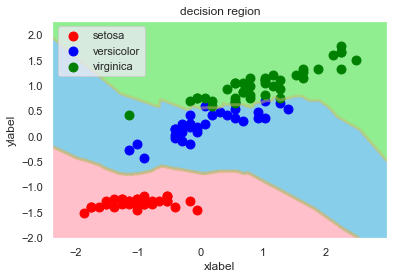

Accuracu:94.7%
Precision:94.2%
Recall:94.2%
f1_score:94.2


In [39]:
# アルゴリズムを指定
knc = KNeighborsClassifier(n_neighbors=3)
# グラフ関数
decision_region2(X1_train, y1_train.ravel(), model= knc)
# 評価関数
score2(X1_train, y1_train.ravel(), X1_test, y1_test, knc)

### 10.3.1 ロジスティック回帰

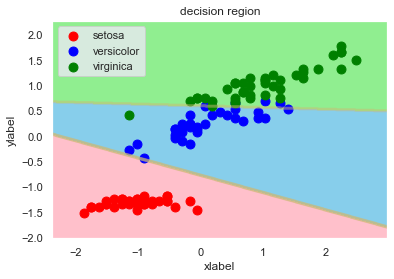

Accuracu:94.7%
Precision:93.9%
Recall:95.8%
f1_score:94.4


In [40]:
# アルゴリズムを指定
lsr = LogisticRegression()
# グラフ関数
decision_region2(X1_train, y1_train.ravel(), model=lsr)
# 評価関数
score2(X1_train, y1_train.ravel(), X1_test, y1_test, lsr)

### 10.4.1 SVM（サポートベクターマシン）

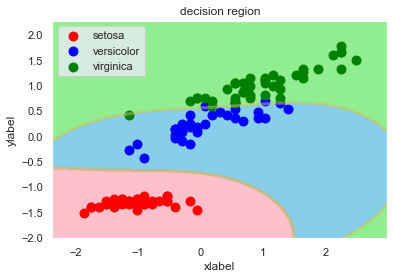

Accuracu:97.4%
Precision:96.7%
Recall:97.9%
f1_score:97.2


In [41]:
# アルゴリズムを指定
svm = SVC(kernel='rbf', C=1.0)
# グラフ関数
decision_region2(X1_train, y1_train.ravel(), model=ｓｖｍ)
# 評価関数
score2(X1_train, y1_train.ravel(), X1_test, y1_test, svm)

### 10.5.1 決定木

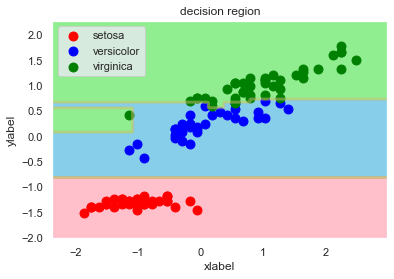

Accuracu:92.1%
Precision:91.9%
Recall:90.5%
f1_score:91.1


In [42]:
# アルゴリズムを指定
tree = DecisionTreeClassifier(max_depth=8)
# グラフ関数
decision_region2(X1_train, y1_train.ravel(), model=tree)
# 評価関数
score2(X1_train, y1_train.ravel(), X1_test, y1_test, tree)

### 10.6.1 ランダムフォレスト

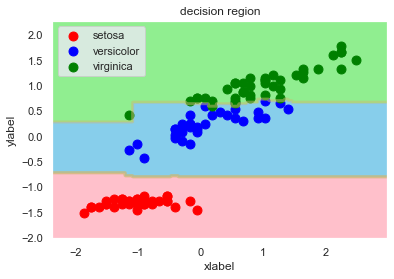

Accuracu:89.5%
Precision:89.7%
Recall:86.8%
f1_score:87.7


In [43]:
# アルゴリズムを指定
rfc = RandomForestClassifier(max_depth=5)
# グラフ関数
decision_region2(X1_train, y1_train.ravel(), model=rfc)
# 評価関数
score2(X1_train, y1_train.ravel(), X1_test, y1_test, rfc)

### 10.7.1 （解答）まとめた指標値

In [44]:
def score_data3(z, model):
    x, y, x1, y1 = z
    model = model.fit(x, y)
    y_pred = model.predict(x1)
    accuracy = accuracy_score(y1, y_pred)
    precision = precision_score(y1, y_pred, average='macro')
    recall = recall_score(y1, y_pred, average='macro')
    f1 = f1_score(y1, y_pred, average='macro')
    return accuracy, precision, recall, f1

In [45]:
score_list3 = [X1_train, y1_train.ravel(), X1_test, y1_test]
knc_score3 = np.array(score_data3(score_list3, knc)).reshape(-1,1)
lsr_score3 = np.array(score_data3(score_list3, lsr)).reshape(-1,1)
svm_score3 = np.array(score_data3(score_list3, svm)).reshape(-1,1)
tree_score3 = np.array(score_data3(score_list3, tree)).reshape(-1,1)
rfc_score3 = np.array(score_data3(score_list3, rfc)).reshape(-1,1)

score_data3 = np.concatenate([knc_score3, lsr_score3, svm_score3, tree_score3, rfc_score3], 1)
score_df3 = pd.DataFrame(score_data3)
score_df3.index = ["accuracy", "precision", "recall", "f1"]
score_df3.columns = ["knc", "lsr", "svm", "tree", "rfc"]
score_df3

,knc,lsr,svm,tree,rfc
accuracy,0.947368,0.947368,0.973684,0.921053,0.921053
precision,0.942130,0.939394,0.966667,0.919118,0.919118
recall,0.942130,0.958333,0.979167,0.905093,0.905093
f1,0.942130,0.944444,0.971703,0.910873,0.910873


それぞれの手法で精度に差が出た。特にSVMは全ての評価がトップ。
最近傍法とロジスティック回帰はほぼ同じぐらいではあるが、最近傍法はprecisionで勝り、ロジスティック回帰はrecallで勝るという特徴がでた。
決定木とランダムフォレストは分類回数を増やして確認したが、30回しても上記の評価であった。